# The Tolman-Eichenbaum Machine: Unifying Space and Relational Memory through Generalization in the Hippocampal Formation.
James C.R.Whittington, Timothy H.Muller, Shirley Mark, Guifen Chen, Caswell Barry, Neil Burgess, Timothy E.J.Behrens.
<!-- ALL-CONTRIBUTORS-BADGE:START - Do not remove or modify this section -->
[![All Contributors](https://img.shields.io/badge/all_contributors-4-orange.svg?style=flat-square)](#contributors-)
<!-- ALL-CONTRIBUTORS-BADGE:END -->

https://www.sciencedirect.com/science/article/pii/S009286742031388X

For a more detailed explanation of TEM's theory and implementation in theis framework, see [Description, Implementation & Analysis of the Tolman-eichenbaum Machine](https://github.com/LukeHollingsworth/Tollman-Eichenbaum-Implementation/blob/main/Description%2C%20Implementation%20and%20Analysis%20of%20the%20Tollman-Eichenbaum%20Machine.pdf).

#### TEM Virtual Environment
This implementation uses an older version of TensorFlow (1.9.0) and subsequently requires Python version 3.6. We suggest setting up a virtual (conda) environment with the following packages:
```
Python>=3.8
PyTorch

matplotlib
numpy
tqdm
```

#### Running TEM
The TEM model is run from the [run script file](whittington_2020_run.py). The model is initialised with default parameters, identical to those in the original publication; this can be found and changed in the [parameters file](../../neuralplayground/agents/whittington_2020_extras/whittington_2020_parameters.py). The model itself can be found [here](../../neuralplayground/agents/whittington_2020_extras/whittington_2020_model.py).

Running should be done on a high-powered computing platform. With 20GB of memory, TEM completes it's full 20,000 iterations of training in approx. 48 hours.

#### Plotting Results
The notebook below plots TEM model performance and its key neural representations, such as grid cells and place cells. Example results are given, however the user is abe so plot the result of locally saved models as well.

First, import the relevant standard and NeuralPlayground Libraries.

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from importlib import util
import neuralplayground.agents.whittington_2020_extras.whittington_2020_parameters as parameters
import neuralplayground.agents.whittington_2020_extras.whittington_2020_analyse as analyse
import neuralplayground.agents.whittington_2020_extras.whittington_2020_plot as plot

/nfs/nhome/live/lhollingsworth/.conda/envs/TorchTEM/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Select trained model
Choose the folder which contains the saved data from the trained TEM model.

In [2]:
pars_orig = parameters.parameters()
params = pars_orig.copy()

date = '2023-03-09'
run = '13'
model_path = os.path.abspath(os.pardir) + '/Summaries2/' + date + '/torch_run' + run + '/model/'
save_path = os.path.abspath(os.pardir) + '/Summaries2/' + date + '/torch_run' + run + '/save/'

#### Load variables
TEM model saves grid and place representations, as well as information on accuracy and zero-shot inference, at the end of training.

In [3]:
environments = [torch.load(save_path + 'environments')]
# environments = torch.load(save_path + 'correct_environments')
g = torch.load(save_path + 'g_all')
p = torch.load(save_path + 'p_all')
correct_model, correct_node, correct_edge = torch.load(save_path + 'correct_all')
zero_shot = torch.load(save_path + 'zero_shot')

#### Choose which environment to plot
For reasons of efficiency, only the trajectory of one environment (within a batch) is saved and can be loaded.

In [4]:
env_to_plot = 0
environment = environments[env_to_plot]
shiny_envs = [False for _ in range(16)]
envs_to_avg = shiny_envs if shiny_envs[env_to_plot] else [not shiny_env for shiny_env in shiny_envs]

#### Plot TEM prediction accuracy
The prediction accuracy of TEM is plotted for the final 5000 steps in training trajectory. This is plotted alongside the proportion of nodes and edges visitied.

Text(0.5, 1.0, 'Zero-shot inference: 13.089005235602095%')

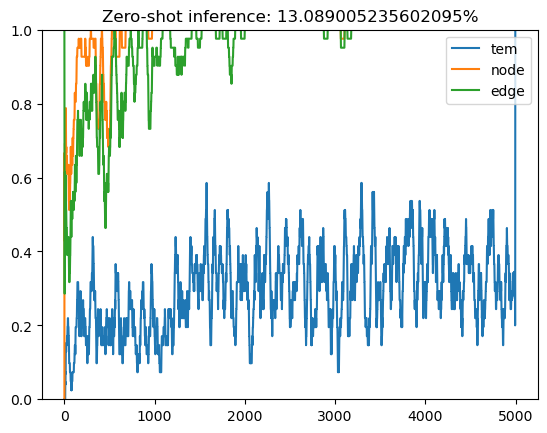

In [5]:
# Plot results of agent comparison and zero-shot inference analysis
filt_size = 41
plt.figure()
plt.plot(analyse.smooth(np.mean(np.array([env for env_i, env in enumerate(correct_model) if envs_to_avg[env_i]]),0)[1:], filt_size), label='tem')
plt.plot(analyse.smooth(np.mean(np.array([env for env_i, env in enumerate(correct_node) if envs_to_avg[env_i]]),0)[1:], filt_size), label='node')
plt.plot(analyse.smooth(np.mean(np.array([env for env_i, env in enumerate(correct_edge) if envs_to_avg[env_i]]),0)[1:], filt_size), label='edge')
plt.ylim(0, 1)
plt.legend()
plt.title('Zero-shot inference: ' + str(np.mean([np.mean(env) for env_i, env in enumerate(zero_shot) if envs_to_avg[env_i]]) * 100) + '%')

#### Plot all cells
Plot both hippocampal and entorhinal cells for all frequency modules.

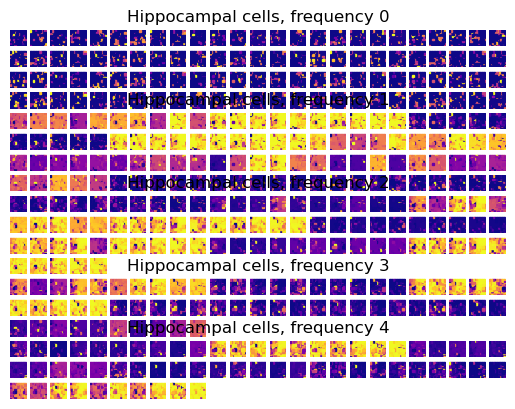

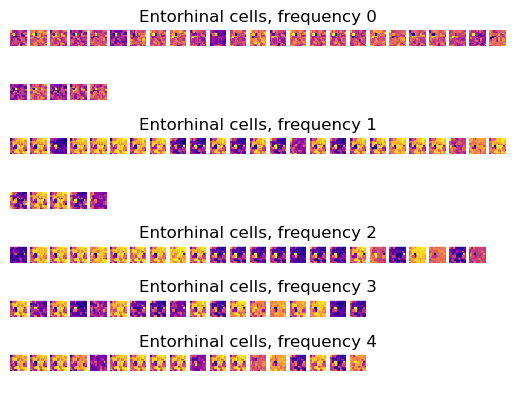

In [6]:
plot.plot_cells(p[env_to_plot], g[env_to_plot], environments[env_to_plot], n_f_ovc=(params['n_f_ovc'] if 'n_f_ovc' in params else 0), columns = 25)
plt.show()

#### Plot single cell
Plot hippocampal or entorhinal cells at a specific frequency module.

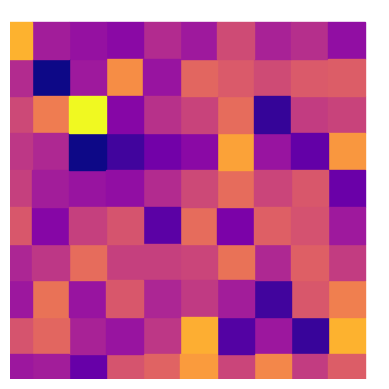

In [7]:
cells = g[env_to_plot]
# Get specific row and column
n_cell = 0
row = 0
col = 0
# Plot rate map for this cell by collection firing rate at each location
loc_rates = cells[n_cell]
plot.plot_map(environment, np.array([loc_rates[l][col] for l in range(len(loc_rates))]), shape='square')
plt.show()

#### Example Trajectory
Below are examples of the discrete random walks taken by TEM in a simple square environment. The left plot shows the trajectory of a single agent and the right shows the combined trajectories of 4 agents in a batch.

<div style="display:flex">
    <img src="https://i.imgur.com/IiOmp1t.png" style="width:50%">
    <img src="https://i.imgur.com/NGSv8az.png" style="width:50%">
</div>

## 4. References
[1] J. C. Whittington, T. H. Muller, S. Mark, G. Chen, C. Barry, N. Burgess, and T. E. Behrens, “The tolman-eichenbaum machine: Unifying space and relational memory through generalization in the hippocampal forma-tion,” Cell, vol. 183, pp. 1249–1263.e23, Nov. 2020.

[2] . Krupic, N. Burgess, and J. O’Keefe, “Neural representations of location composed of spatially periodic bands," Science, vol. 337, pp. 853–857, Aug. 2012.

[3] E. C. Tolman, “Cognitive maps in rats and men.,” Psychological Review, vol. 55, no. 4, pp. 189–208, 1948.

[4] S. S. Deshmukh and J. J. Knierim, “Representation of non-spatial and spatial information in the lateral entorhinal cortex,” Frontiers in Behavioral Neuroscience, vol. 5, 2011.

[5] F. Savelli, D. Yoganarasimha, and J. J. Knierim, “Influence of boundary removal on the spatial representations
of the medial entorhinal cortex,” Hippocampus, vol. 18, pp. 1270–1282, Dec. 2008.

[6] M. L. Shapiro, H. Tanila, and H. Eichenbaum, “Cues that hippocampal place cells encode: Dynamic and hierarchical representation of local and distal stimuli,” Hippocampus, vol. 7, no. 6, pp. 624–642, 1997.